In [1]:
"""
This loosely code follows the steps outlined by: 

https://cprosenjit.medium.com/multivariate-time-series-forecasting-using-xgboost-1728762a9eeb
"""

'\nThis loosely code follows the steps outlined by: \n\nhttps://cprosenjit.medium.com/multivariate-time-series-forecasting-using-xgboost-1728762a9eeb\n'

In [2]:
import numpy as np 
import pandas as pd
from pyGRNN import GRNN
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV, RidgeCV

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
def format_data(pathname):
    df = pd.read_excel(pathname)
    df2 = df.drop(columns=['Country Name', 'Country Code'])
    df2 = df2.dropna(axis=1, how='all')
    
    return df2

In [5]:
def fill_na(data):
    
    df4 = data.fillna(data.mean())
    df4.drop(data.tail(1).index,inplace=True) #remove last row
    
    return df4

In [6]:
def x_and_y(data):

    X = data.drop(columns='GDP growth (annual %)')
    y = data['GDP growth (annual %)']
    
    return X, y

In [7]:
"""
Feature Selection using Lasso Regression

with help from https://towardsdatascience.com/build-better-regression-models-with-lasso-271ce0f22bd
"""
def lassoFeatSelect(X, y, X_train, X_test, y_train, y_test):
    featurenames = X.columns.values.tolist()
    
    lasso_pipe = make_pipeline(preprocessing.StandardScaler(), LassoCV())
    lasso_pipe.fit(X_train, y_train)
    y_pred = lasso_pipe.predict(X_test)
    np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    lasso_pipe_coef = lasso_pipe[-1].coef_
    lasso_selected = list(zip(featurenames, lasso_pipe_coef))
    
    dflasso = pd.DataFrame(lasso_selected)
    dflasso = dflasso.rename(columns={0 : 'Indicator', 1 : 'CoefVal'})
    dfLassoFeatures = dflasso[dflasso['CoefVal'] != 0]
    lassoFeatureNames = dfLassoFeatures.Indicator.tolist()
    
    return lassoFeatureNames

In [8]:
"""
Ridge Regression feat selection

with help from https://towardsdatascience.com/build-better-regression-models-with-lasso-271ce0f22bd
"""

def ridgeFeatSelect(X, y, X_train, X_test, y_train, y_test):
    featurenames = X.columns.values.tolist()
    
    ridge_pipe = make_pipeline(preprocessing.StandardScaler(), RidgeCV(alphas=np.arange(0.1,1.0, 0.001)))
    ridge_pipe.fit(X_train, y_train)
    y_pred = ridge_pipe.predict(X_test)
    
    ridge_pipe_coef = ridge_pipe[-1].coef_
    ridge_selected = list(zip(featurenames, ridge_pipe_coef))


    dfRidge = pd.DataFrame(ridge_selected)
    dfRidge = dfRidge.rename(columns={0 : 'Indicator', 1 : 'CoefVal'})
    dfRidgeFeatures = dfRidge[dfRidge['CoefVal'] != 0]
    ridgeFeatureNames = dfRidgeFeatures.Indicator.tolist()

    return ridgeFeatureNames

In [9]:
"""
combination of from: https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
and
github documentation
"""

def tune_n(X, y):
    hyperparam = {'kernel' : ["RBF"],
                  'sigma' : list(np.arange(2, 5, 0.001)),
                  'calibration' : ['none'],
                  'method' : ['Nelder-Mead']
                  }
    
    model = GRNN()
    
    gscv = GridSearchCV(estimator=model, param_grid=hyperparam,
                       scoring='neg_mean_squared_error',
                       verbose=1, cv=10, return_train_score=True)
    
    gscv.fit(X, y)
    
    print("best hyperparam:", gscv.best_params_)

In [10]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)

In [11]:
data = format_data('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Multivariate More.xlsx')
data2 = data.set_index('Year')
filled = fill_na(data2)

In [44]:
X = filled.drop(columns='GDP growth (annual %)')
y = filled['GDP growth (annual %)']

X_feat = filled[['Unemployment, female (% of female labor force) (modeled ILO estimate)', 'Foreign direct investment, net outflows (BoP, current US$).1', 'Portfolio investment, net (BoP, current US$).1', 'Foreign direct investment, net inflows (BoP, current US$).1', 'Portfolio equity, net inflows (BoP, current US$).1', 'S&P Global Equity Indices (annual % change)', 'Market capitalization of listed domestic companies (current US$)', 'Market capitalization of listed domestic companies (% of GDP)', 'Listed domestic companies, total', 'Stocks traded, turnover ratio of domestic shares (%)', 'Portfolio investment, bonds (PPG + PNG) (NFL, current US$)', 'Domestic credit to private sector by banks (% of GDP)', 'Bank liquid reserves to bank assets ratio (%)', 'Total reserves in months of imports', 'Claims on other sectors of the domestic economy (annual growth as % of broad money)', 'Net domestic credit (current LCU)', 'Net foreign assets (current LCU)', 'Broad money (current LCU)', 'Interest rate spread (lending rate minus deposit rate, %)', 'Claims on central government, etc. (% GDP)', 'Claims on other sectors of the domestic economy (% of GDP)', 'Domestic credit provided by financial sector (% of GDP)', 'Domestic credit to private sector (% of GDP)', 'Depth of credit information index (0=low to 8=high)', 'Private credit bureau coverage (% of adults)', 'Public credit registry coverage (% of adults)', 'Strength of legal rights index (0=weak to 12=strong)', 'Trade in services (% of GDP)', 'Imports of goods and services (BoP, current US$)', 'Foreign direct investment, net outflows (BoP, current US$)', 'Current account balance (% of GDP)', 'Net errors and omissions (BoP, current US$)', 'Exports of goods and services (BoP, current US$)', 'Goods exports (BoP, current US$)', 'Exports of goods, services and primary income (BoP, current US$)', 'Foreign direct investment, net inflows (BoP, current US$)', 'Portfolio equity, net inflows (BoP, current US$)', 'External debt stocks, total (DOD, current US$)', 'External debt stocks (% of GNI)', 'General government final consumption expenditure (annual % growth)', 'Exports of goods and services (annual % growth)', 'Changes in inventories (current US$)', 'External balance on goods and services (constant LCU)', 'Agriculture, forestry, and fishing, value added (annual % growth)', 'Adjusted savings: education expenditure (current US$)', 'Adjusted savings: carbon dioxide damage (current US$)', 'Adjusted savings: carbon dioxide damage (% of GNI)', 'Adjusted savings: consumption of fixed capital (current US$)', 'Adjusted savings: consumption of fixed capital (% of GNI)', 'Adjusted savings: mineral depletion (current US$)', 'Adjusted net national income (current US$)', 'Adjusted net national income per capita (annual % growth)', 'Discrepancy in expenditure estimate of GDP (constant LCU)', 'GDP, PPP (current international $)', 'GDP per capita growth (annual %)', 'GNI, Atlas method (current US$)', 'GNI growth (annual %)', 'GNI per capita, Atlas method (current US$)', 'GNI per capita growth (annual %)', 'Net primary income (Net income from abroad) (current US$)', 'Taxes less subsidies on products (current US$)', 'Taxes less subsidies on products (current LCU)', 'Net secondary income (Net current transfers from abroad) (current US$)', 'Net secondary income (Net current transfers from abroad) (current LCU)', 'PPP conversion factor, GDP (LCU per international $)']]
#X_lasso = filled[lassoFeatSelected]
#X_ridge = filled[ridgeFeatSelected]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)


#StandardScaler as data follows normal dist

scaler = preprocessing.StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

In [13]:
lassoFeatSelected = lassoFeatSelect(X, y, X_train, X_test, y_train, y_test)
ridgeFeatSelected = ridgeFeatSelect(X, y, X_train, X_test, y_train, y_test)

In [39]:
#Hyper param tuning
tune_n(X_train_s, y_train) 

Fitting 10 folds for each of 3000 candidates, totalling 30000 fits
best hyperparam: {'calibration': 'none', 'kernel': 'RBF', 'method': 'Nelder-Mead', 'sigma': 2.0}


In [48]:
model = GRNN(kernel='RBF',calibration='none',sigma=4.99899999999967, method='Nelder-Mead')
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)

RMSE:  0.8401833706966623
MAPE:  14.535701950436723
MAE:  0.7790043506073833
Scatter Index:  15.558040646603349
MDA:  0.6363636363636364
Mean of actual:  5.400316079519256


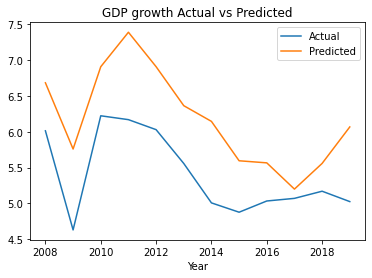

In [49]:
#Outputs
df_compare = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
df_compare.plot(title='GDP growth Actual vs Predicted')
performance_metrics(y_test, y_pred)

In [17]:
"""
Feature Selection Solve

from pyGRNN github documentation
"""

from pyGRNN import feature_selection as FS

featurenames = X.columns.values.tolist()

#selector = FS.Isotropic_selector(bandwidth = 'rule-of-thumb')
#selector.feat_selection(X.to_numpy(), y.ravel(), feature_names=featurenames, strategy='bfs', 
#                        stop_criterion='first_min')


#4 lines copied from documentation

<AxesSubplot:title={'center':'Distribution Plot'}, ylabel='Frequency'>

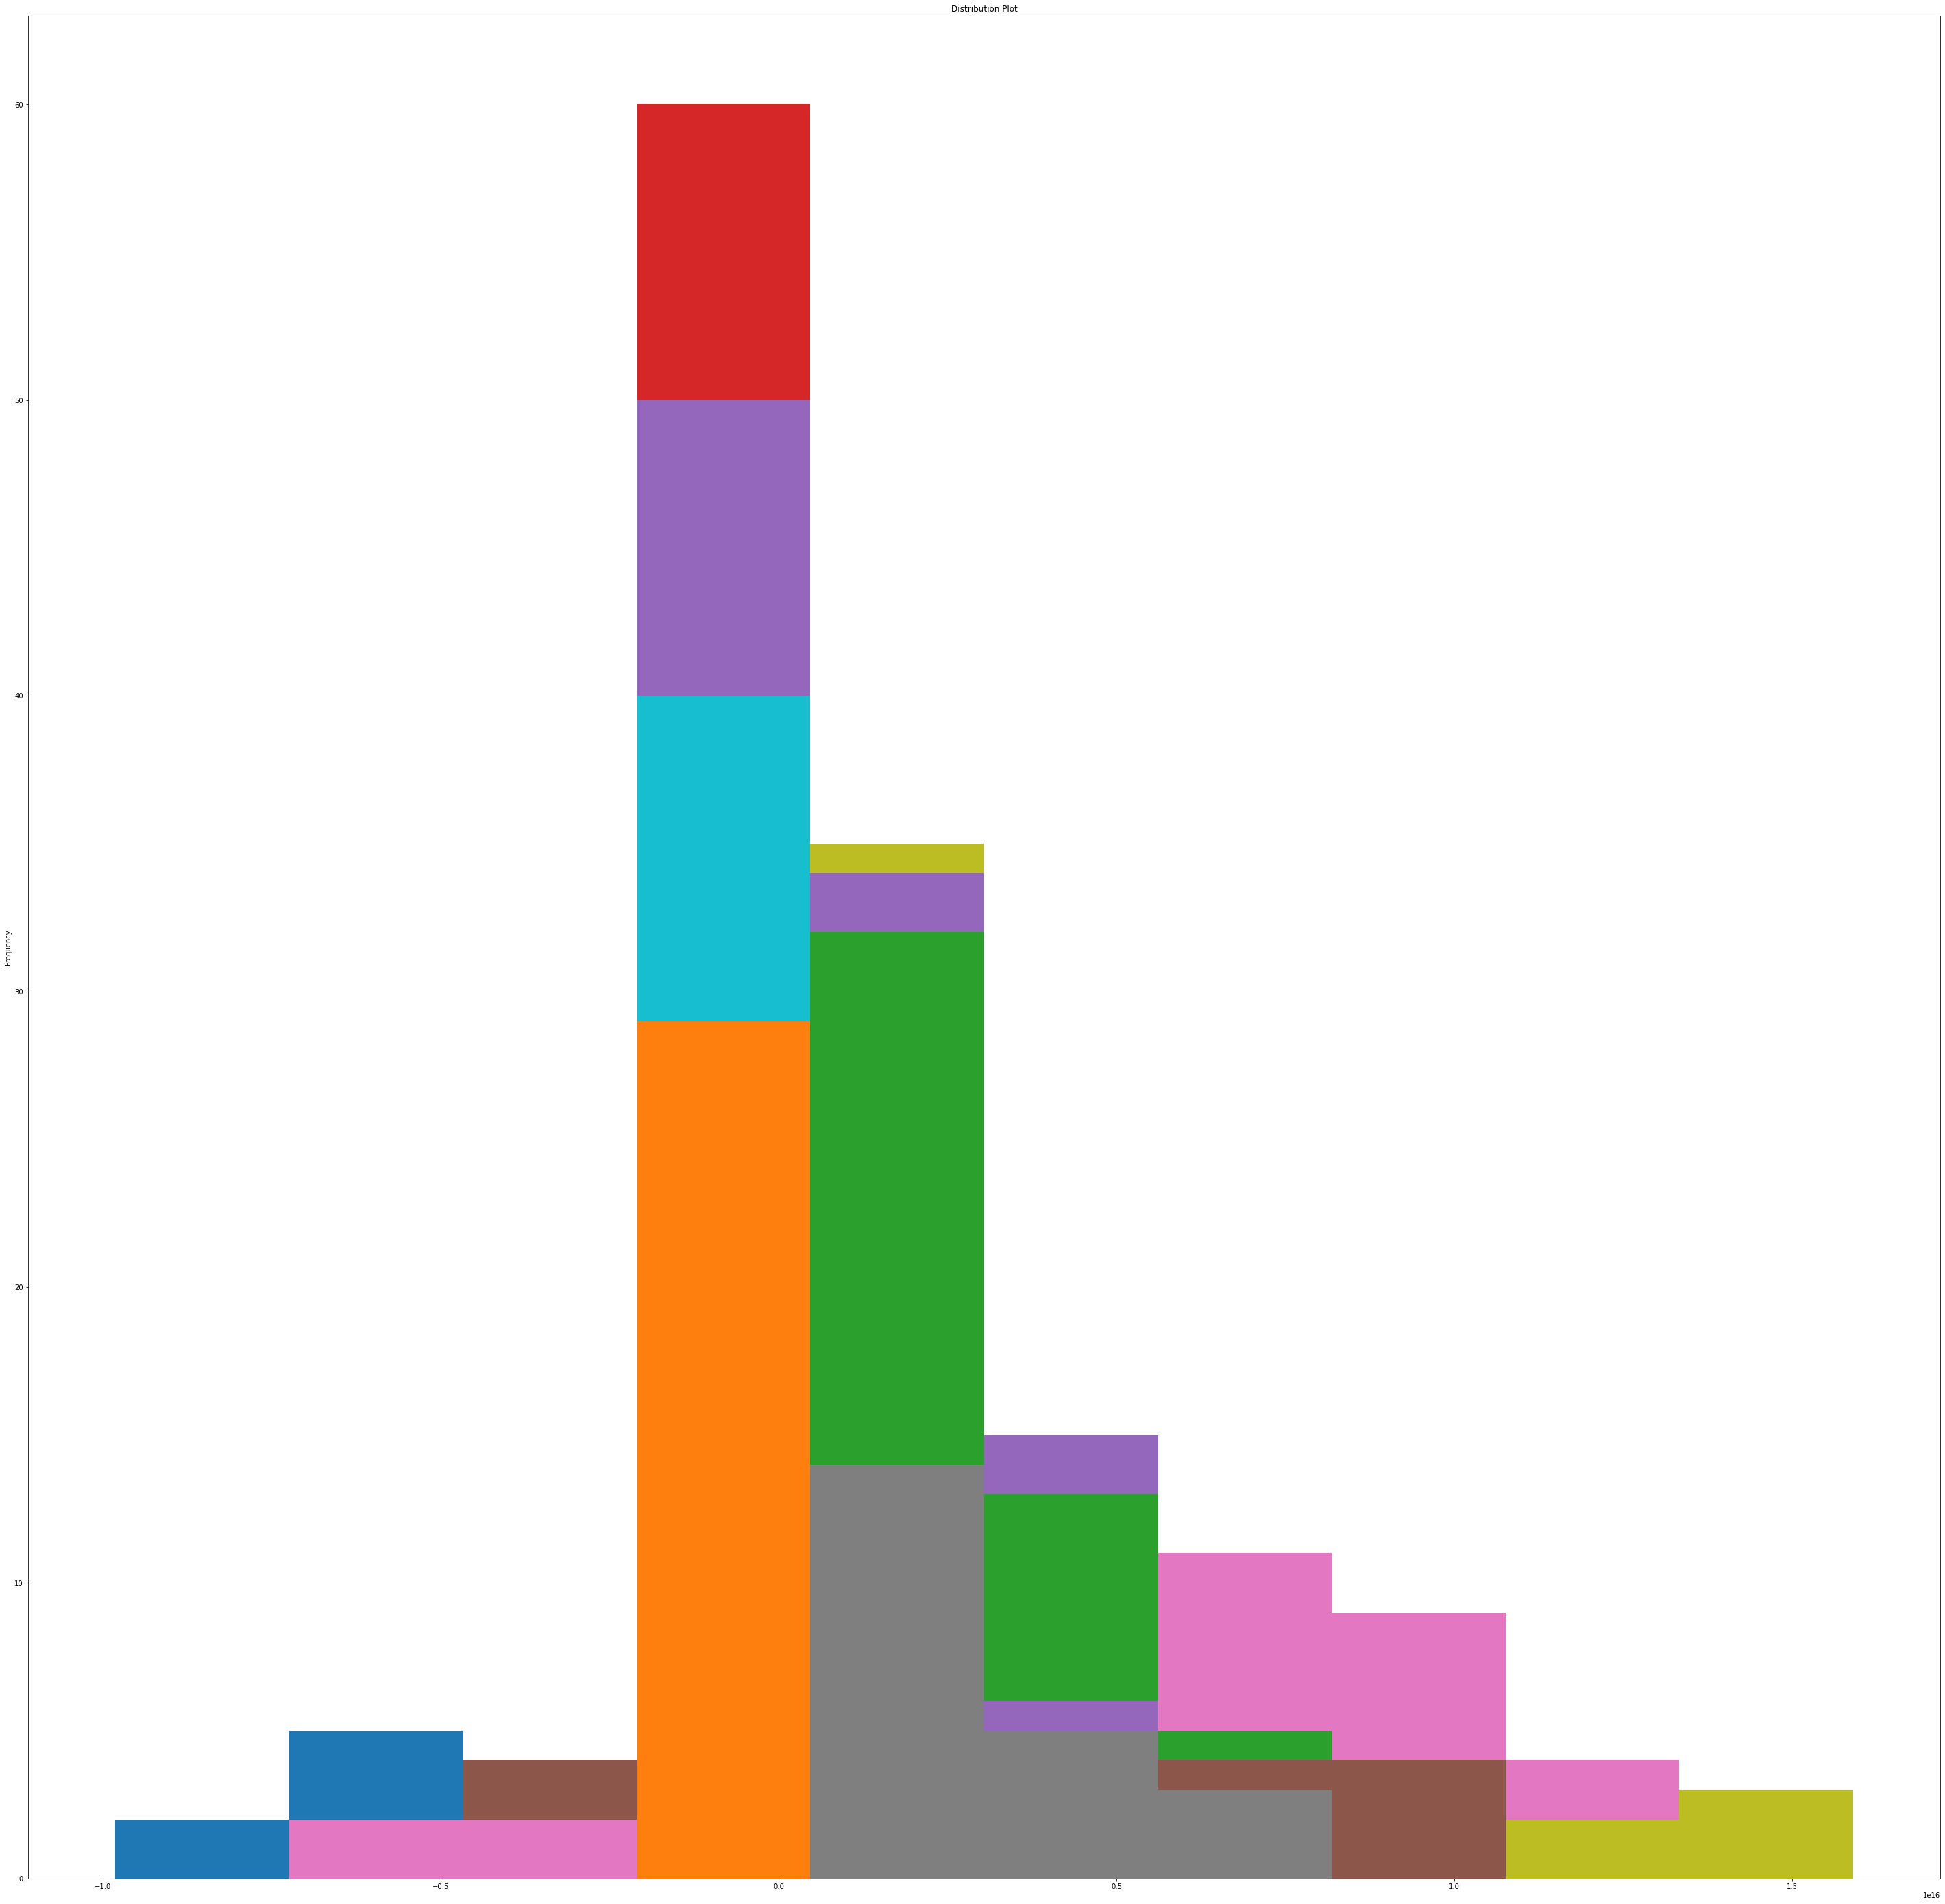

In [18]:
"""
Distribution plot from pandas documentation
"""

data2.plot.hist(title='Distribution Plot',legend=False, figsize=(50,50))

#1 line from documentation

Text(0.5, 1.0, 'Learning Curve for GRNN Before FS After HT')

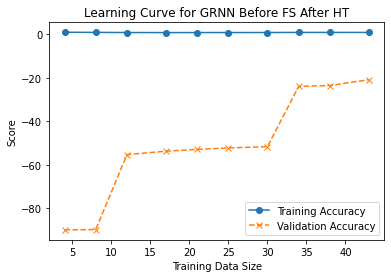

In [53]:
"""
Learning Curve to detect overfit/underfit

Method from: 

https://vitalflux.com/learning-curves-explained-python-sklearn-example/amp/
and
https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html#:~:text=Learning%20curves%20can%20be%20generated,see%20in%20the%20following%20examples.
"""

pipeline = make_pipeline(preprocessing.StandardScaler(), model)

train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X_train,
                                                      y=y_train, cv=10,
                                                      train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, marker='o', label='Training Accuracy')
plt.xlabel('Training Data Size')
plt.plot(train_sizes, test_mean, marker='x', linestyle='--', label='Validation Accuracy')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curve for GRNN Before FS After HT')


In [51]:
train_mean

array([0.99867969, 0.93108483, 0.87081668, 0.84716144, 0.85727361,
       0.86135516, 0.87544684, 0.92094913, 0.91701043, 0.9247054 ])

In [52]:
test_mean

array([-89.96234235, -89.80247682, -55.30425734, -53.73679042,
       -52.90829062, -52.24497752, -51.64889085, -23.91254569,
       -23.51631695, -20.83640174])

In [36]:
"""82 Lines of code"""

'82 Lines of code'